In [1]:
import os
import sys
import math

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import torch
from PIL import Image
from IPython.display import HTML

In [3]:
sys.path.append("../")
import models
from utils import data, graphics

# Config

In [4]:
# Config
base_dir = "..\\data\\original\\original_data"
base_fusion_dir = "..\\data\\backup\\japeal_renamed"
model_prefix = f"..\\outputs\\tbd\\"

batch_size = 64
image_size = 64
use_noise_images = True

vq_vae_model_name = f"vq_vae_v5.10"
vq_vae_num_layers = 0
vq_vae_max_filters = 512
vq_vae_use_max_filters = True
vq_vae_num_embeddings = 256
vq_vae_embedding_dim = 32
vq_vae_commitment_cost = 0.25
vq_vae_small_conv = True  # To use the 1x1 convolution layer

prior_model_name = f"fusion_cnn_prior_v2"
prior_input_channels = 6  # Two Images
prior_output_dim = image_size // np.power(2, vq_vae_num_layers)

In [5]:
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")

In [6]:
transform = data.image2tensor_resize(image_size)

# Utility Functions

In [7]:
def load_data(data_folder, image_size, transform):
    pokemon = {}
    background = Image.new("RGBA", (image_size, image_size), (255, 255, 255))
    for file in os.listdir(data_folder):
        id_ = file.split('.')[0].split('_')[0].split('-')[0]
        form = '_'.join(file.split('.')[0].split('_')[1:])
        image = Image.open(os.path.join(data_folder, file))
        image = image.resize((image_size, image_size), resample=Image.BICUBIC).convert("RGBA")
        image = Image.alpha_composite(background, image).convert("RGB")
        if id_ not in pokemon:
            pokemon[id_] = {}
        pokemon[id_][form] = transform(image)
    return pokemon

In [8]:
def plot_images(images):
    fig = plt.figure(figsize=(8,8))
    num_cols = len(images) if len(images) < 4 else 4
    num_rows = math.ceil(len(images) / num_cols)
    for i, image in enumerate(images):
        fig.add_subplot(num_rows, num_cols, i+1)
        image = image.detach().permute(1, 2, 0).numpy()
        plt.imshow(image)

In [9]:
def animation_func(images, height, width, fig, axis):
    i, j = 0, 0
    for num, image in enumerate(images):
        if num == height * width:
            break
        image = image.detach().permute(1, 2, 0).numpy()
        if height == width == 1:
            axis.imshow(image)
        elif len(axis.shape) == 1:
            axis[j].imshow(image)
        else:
            axis[i, j].imshow(image)
        if j == width - 1:
            j = 0
            i += 1
        else:
            j += 1
    return fig, axis

In [10]:
def make_animation(animation_func, all_samples, height=4, width=4):
    fig, axis = plt.subplots(height, width, figsize=(8, 6), dpi=80)
    anim = animation.FuncAnimation(
        fig=fig,
        func=animation_func,
        frames=all_samples,
        fargs=(height, width, fig, axis),
        interval=300,
        repeat=False,
    )
    return anim

# Load Model

In [13]:
model = models.VQVAE(
    num_layers=vq_vae_num_layers,
    input_image_dimensions=image_size,
    small_conv=vq_vae_small_conv,
    embedding_dim=vq_vae_embedding_dim,
    num_embeddings=vq_vae_num_embeddings,
    commitment_cost=vq_vae_commitment_cost,
    max_filters=vq_vae_max_filters,
    use_max_filters=vq_vae_use_max_filters,
)

In [14]:
model_path = os.path.join(model_prefix, vq_vae_model_name, "model.pt")
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [15]:
model.eval()

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(256, 32)
  )
  (decoder): Sequential(
    (0): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvTranspose2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Sigmoid()
  )
)

In [292]:
prior = models.CNNPrior(
    input_channels=prior_input_channels,
    output_channels=vq_vae_num_embeddings,
    input_dim=image_size,
    output_dim=prior_output_dim,
)

In [17]:
model_path = os.path.join(model_prefix, prior_model_name, "model.pt")
prior.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [293]:
prior.eval()

CNNPrior(
  (model): Sequential(
    (0): Conv2d(6, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
)

# Load Data

In [19]:
pokemon = load_data(base_dir, image_size, transform)

In [306]:
x = [pokemon['005']['base_bw'], pokemon['007']['base_bw']]

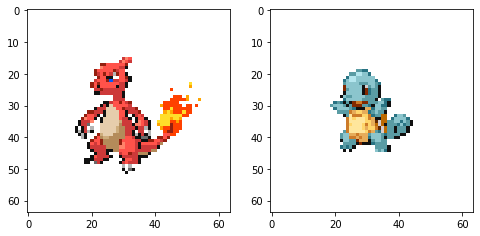

In [307]:
plot_images(x)

In [281]:
predict = torch.stack(x)
with torch.no_grad():
    _, y, _, y_indices = model(predict)

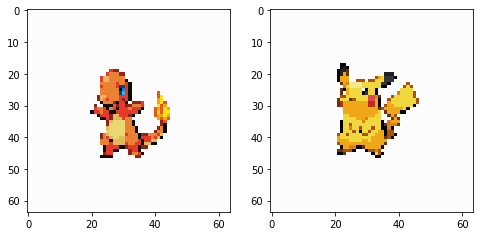

In [282]:
plot_images(y)

In [283]:
print(f"Num. Encodings = {int(y_indices.shape[0] / predict.shape[0])}")

Num. Encodings = 4096


# Evaluating Prior

In [294]:
predict = torch.cat([torch.stack(x), torch.stack(x)], dim=1)
with torch.no_grad():
    # Get Encoding
    encoding = prior(predict).argmax(dim=1).flatten(start_dim=1).view(-1, 1)
    # Decode
    height = width = np.sqrt(encoding.shape[0] / predict.shape[0]).astype(np.int32)
    target_shape = (predict.shape[0], height, width, vq_vae_embedding_dim) 
    out = model.quantize_and_decode(encoding, target_shape, device)

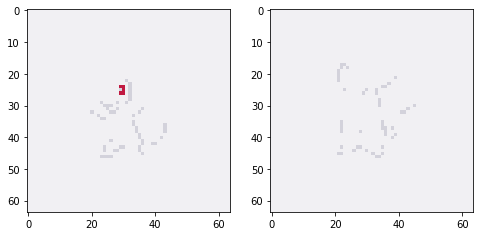

In [295]:
plot_images(out)

In [27]:
predict = torch.cat([torch.stack([x[0], x[1]]), torch.stack([x[1], x[0]])], dim=1)
with torch.no_grad():
    # Get Encoding
    encoding = prior(predict).argmax(dim=1).flatten(start_dim=1).view(-1, 1)
    # Decode
    height = width = np.sqrt(encoding.shape[0] / predict.shape[0]).astype(np.int32)
    target_shape = (predict.shape[0], height, width, vq_vae_embedding_dim) 
    out = model.quantize_and_decode(encoding, target_shape, device)

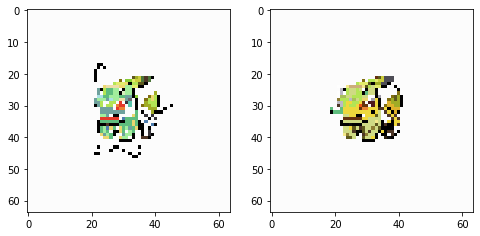

In [28]:
plot_images(out)

In [329]:
mask = (torch.stack([x[0], x[1]]) == torch.stack([x[0], x[0]])).flatten(start_dim=1).all(dim=1)

In [361]:
torch.index_select(torch.stack(x), 0, mask.int()).shape

torch.Size([2, 3, 64, 64])

In [365]:
torch.logical_not(mask)

tensor([False,  True])

In [296]:
prior.train()
optimizer = torch.optim.Adam(prior.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

In [312]:
optimizer.zero_grad()
predict = torch.cat([torch.stack(x), torch.stack(x)], dim=1)
out = prior(predict).argmax(dim=1).flatten(start_dim=1).view(-1, 1)
target_shape = (predict.shape[0], prior_output_dim, prior_output_dim, vq_vae_embedding_dim) 
out = model.quantize_and_decode(out, target_shape, device)
loss = criterion(out, torch.stack(x))
loss.backward()

In [313]:
loss.item()

0.03716480731964111

In [314]:
optimizer.step()

In [322]:
torch.equal(test, prior.model[0].weight)

True

In [297]:
test = prior.model[0].weight.clone()

# Exploration of Latent Space

In [159]:
steps = int(y_indices.shape[0] / len(predict))
target_indices = np.asarray([steps * i for i in range(len(predict))])

In [160]:
target_indices = np.asarray([i+5 for i in range(y_indices.shape[0]) if i % 32 == 0])

In [161]:
target_indices

array([   5,   37,   69,  101,  133,  165,  197,  229,  261,  293,  325,
        357,  389,  421,  453,  485,  517,  549,  581,  613,  645,  677,
        709,  741,  773,  805,  837,  869,  901,  933,  965,  997, 1029,
       1061, 1093, 1125, 1157, 1189, 1221, 1253, 1285, 1317, 1349, 1381,
       1413, 1445, 1477, 1509, 1541, 1573, 1605, 1637, 1669, 1701, 1733,
       1765, 1797, 1829, 1861, 1893, 1925, 1957, 1989, 2021])

In [163]:
height = width = np.sqrt(y_indices.shape[0] / predict.shape[0]).astype(np.int32)
target_shape = (predict.shape[0], height, width, embedding_dim) 
all_outputs = []
for i in range(num_embeddings):
    test = y_indices.clone()
    test[target_indices] = i
    with torch.no_grad():
        out = model.quantize_and_decode(test, target_shape, device)
        all_outputs.append(out)

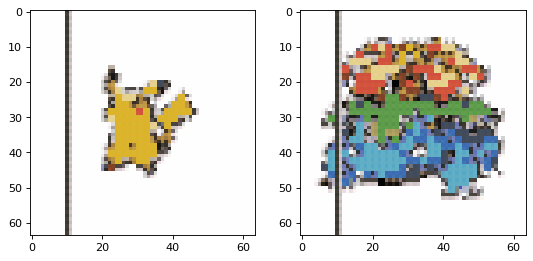

In [164]:
anim = make_animation(animation_func, all_outputs, height=1, width=2)
HTML(anim.to_html5_video())

In [169]:
test = y_indices.clone()
test[63:69][:] = 0
with torch.no_grad():
    height = width = np.sqrt(y_indices.shape[0] / predict.shape[0]).astype(np.int32)
    target_shape = (predict.shape[0], height, width, embedding_dim) 
    out = model.quantize_and_decode(test, target_shape, device)
    all_outputs.append(out)

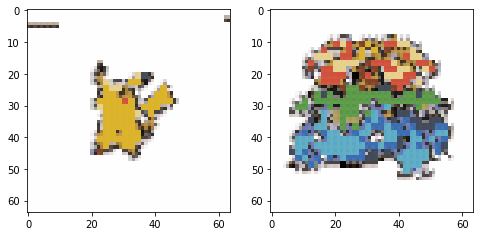

In [170]:
plot_images(out)

# Mix & Match Fusion

In [36]:
y1 = x[0].unsqueeze(0)
y2 = x[1].unsqueeze(0)
with torch.no_grad():
    _, _, _, y1_indices = model(y1)
    _, _, _, y2_indices = model(y2)

In [37]:
all_outputs = []
with torch.no_grad():
    for j in range(10):
        final = torch.zeros_like(y1_indices)
        for i, _ in enumerate(final):
            if torch.rand(1) < 0.5:
                final[i] = y1_indices[i]
            else:
                final[i] = y2_indices[i]
        height = width = np.sqrt(final.shape[0] / y1.shape[0]).astype(np.int32)
        target_shape = (y1.shape[0], height, width, embedding_dim) 
        out = model.quantize_and_decode(final, target_shape, device)
        all_outputs.append(out)

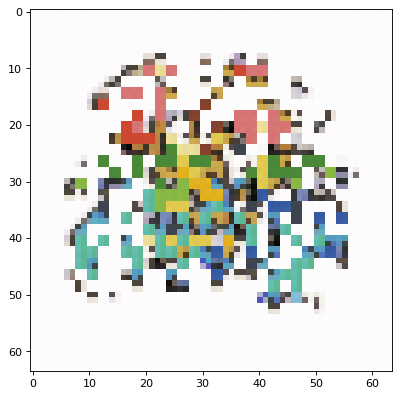

In [38]:
anim = make_animation(animation_func, all_outputs, height=1, width=1)
HTML(anim.to_html5_video())

# Half & Half Fusions

In [324]:
y1 = x[0].unsqueeze(0)
y2 = x[1].unsqueeze(0)
with torch.no_grad():
    _, _, _, y1_indices = model(y1)
    _, _, _, y2_indices = model(y2)

In [338]:
all_outputs = []
with torch.no_grad():
    for j in range(10):
        final = torch.cat((y1_indices[:512], y2_indices[512:]))
        height = width = np.sqrt(final.shape[0] / y1.shape[0]).astype(np.int32)
        target_shape = (y1.shape[0], height, width, embedding_dim) 
        out = model.quantize_and_decode(final, target_shape, device)
        all_outputs.append(out)

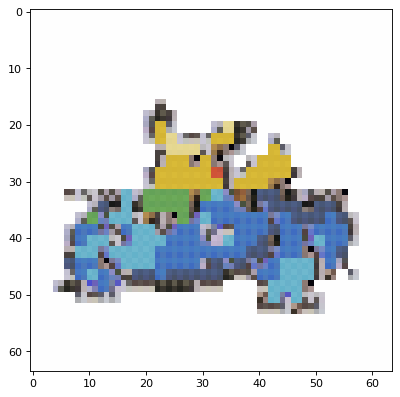

In [339]:
anim = make_animation(animation_func, all_outputs, height=1, width=1)
HTML(anim.to_html5_video())

# Fusions

In [63]:
x = Image.open("..\\data\\final\\fusions\\fusion_test\\both\\8.445.whiteBG.png")

In [64]:
_, out, _, _ = model(transform(x).unsqueeze(0))

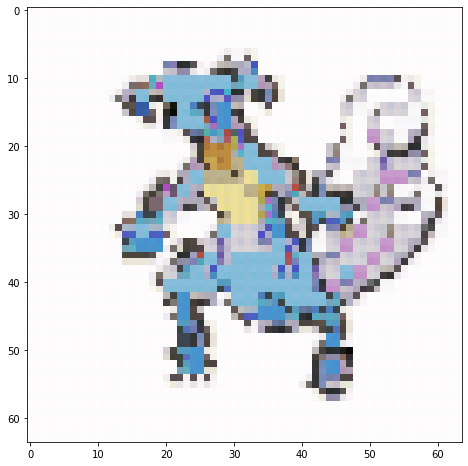

In [65]:
plot_images(out)

# Checking Encoding Usage

In [316]:
all_indices = []
num_indices = []
for x in pokemon:
    if "base_bw" in pokemon[x]:
        x = pokemon[x]["base_bw"]
    elif "base_hgss" in pokemon[x]:
        x = pokemon[x]["base_hgss"]
    else:
        x = pokemon[x]["base_plat"]
    _, _, _, indices = model(x.unsqueeze(0))
    all_indices.append(indices)
    num_indices.append(len(indices.unique()))
for x in pokemon:
    if "base_shiny_bw" in pokemon[x]:
        x = pokemon[x]["base_shiny_bw"]
    elif "base_shiny_hgss" in pokemon[x]:
        x = pokemon[x]["base_shiny_hgss"]
    else:
        x = pokemon[x]["base_shiny_plat"]
    _, _, _, indices = model(x.unsqueeze(0))
    all_indices.append(indices)
    num_indices.append(len(indices.unique()))

In [317]:
np.mean(num_indices)

23.919876733436055

In [318]:
len(torch.stack(all_indices).flatten().unique())

46

In [267]:
torch.stack(all_indices).flatten().unique()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127])